In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This code defines a Value class representing variables in a computational graph, enabling automatic differentiation through operations like addition, multiplication, and tanh. It also implements backpropagation to calculate gradients for the entire expression:

In [2]:
class Value:
    """
    Represents a variable in a computational graph.
    """
    
    def __init__(self, data, _children=(), _op='', label=''):
        """
        Initializes the Value object.
        
        Args:
            data: The actual value of the variable.
            _children: (Optional) Set of previous value objects used to create this value.
            _op: (Optional) String indicating the operation used to create this value.
            label: Label for the value.
        """
        self.data = data
        self.grad = 0.0 # Intially assumes no impact on output
        self._backward = lambda: None # Placeholder for backpropagation function
        self._prev = set(_children) # Set of previous values
        self._op = _op # Operation used to create this value
        self.label = label

    def __repr__(self):
        """
        String representation of the Value object.
        """
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        """
        Addition operation for Value objects.
        
        Args:
            other: Another Value object.
        
        Returns:
            A new Value object representing the sum.
        """
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            """
            Backpropagation for addition.
            """
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        """
        Multiplication operation for Value objects.
        
        Args:
            other: Another Value object.
        
        Returns:
            A new Value object representing the product.
        """
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            """
            Backpropagation for multiplication.
            """
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        """
        Applies the tanh function to the Values object's data.
        
        Returns:
            A new Value object representing the tanh result.
        """
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            """
            Backpropagation for tanh.
            """
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        """
        Manually implements backpropagation for the entire expression.
        """
        topo = [] # Topological order of nodes
        visited = set() # Set of visited nodes
        def build_topo(v):
            """
            Helper function for topological sort.
            """
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0 # base case        
        for node in reversed(topo):
            # Apply backpropagation function for each node
            node._backward()

This code allows you to visualize the computational graph of your symbolic expression. It creates a visual representation of the nodes (operations and data) and their connections (dependencies), making it easier to understand how the expression is evaluated and how gradients flow through the network:

In [3]:
from graphviz import Digraph

def trace(root):
    """
    Builds a set of all nodes and edges in the computational graph.
    
    Args:
        root: The root node of the graph.
        
    Returns:
        nodes: Set of all Value objects in the graph.
        edges: Set of tuples representing edges between nodes.
    """
    nodes, edges = set(), set()
    def build(v):
        """
        Helper function to recursively explore the graph.
        """
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    
    return nodes, edges

def draw_dot(root):
    """
    Creates a Graphviz dot object representing the computational graph.
    
    Args:
        root: The root node of the graph.
        
    Returns:
        dot: A Graphviz dot object
    """
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = Left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # create a rectangular node for each value, displaying its label, data, and gradient
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        # if this value is a result of some operation, create and connect an op node
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

In [4]:
# inputs x1, x2 (2D)
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2, of the neuron (synaptic strengths for each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b ('cell body of neuron')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
# output
o = n.tanh(); o.label = 'o'

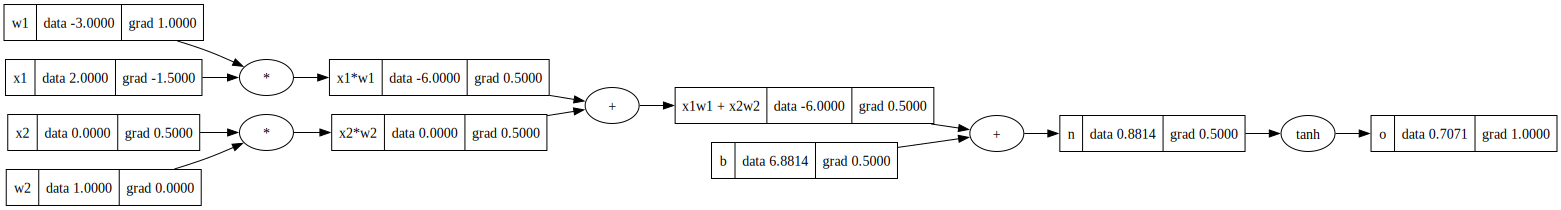

In [6]:
o.backward()
draw_dot(o)